In [1]:
# Setting optimal number of threads for kmeans:
%env OMP_NUM_THREADS=1
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
import pylab
import os
import traceback
from statannotations.Annotator import Annotator
# allow us to see results under cell code
%matplotlib inline

env: OMP_NUM_THREADS=1


# Comparing all groups to check statistical difference among the clusters

### Set working directory

In [2]:
#### Check current working directory
current_directory = os.getcwd()
print(current_directory)

#### Set working directory
os.chdir('C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering\\df_to_merge')

#### Check if the working directory changes
current_directory = os.getcwd()
print(current_directory)

C:\Users\Alek\Desktop\Github_commits\Trajectory_clustering
C:\Users\Alek\Desktop\Github_commits\Trajectory_clustering\df_to_merge


### Reading, striping, merging data frames

In [3]:
def read_csv_files(file_names):
    """
    Read multiple CSV files into Pandas DataFrames.

    Args:
        file_names (list): A list of CSV file names (including extensions) to be read.

    Returns:
        dict: A dictionary where keys are DataFrame names and values are corresponding DataFrames.
    """
    # Create an empty dictionary to store DataFrames
    dataframes = {}

    # Iterate over the provided CSV file names and read them into DataFrames
    for csv_file in file_names:
        # Use the file name (without extension) as the key for the DataFrame
        df_name = os.path.splitext(csv_file)[0]
        # Read the CSV file into a DataFrame
        dataframes[df_name] = pd.read_csv(csv_file)

    return dataframes

In [4]:
# Provide a list of CSV file names you want to read
cr_to_merge = ['cr_to_merge_df_1.csv', 'cr_to_merge_df_2.csv', 'cr_to_merge_df_3.csv', 'cr_to_merge_df_4.csv', 'cr_to_merge_df_5.csv']
msls_to_merge = ['msls_to_merge_df_1.csv', 'msls_to_merge_df_2.csv', 'msls_to_merge_df_3.csv', 'msls_to_merge_df_4.csv', 'msls_to_merge_df_5.csv']
change_rate_to_merge = ['change_rate_to_merge_df_1.csv', 'change_rate_to_merge_df_2.csv', 'change_rate_to_merge_df_3.csv', 'change_rate_to_merge_df_4.csv', 'change_rate_to_merge_df_5.csv']
total_distance_to_merge = ['total_distance_to_merge_df_1.csv', 'total_distance_to_merge_df_2.csv', 'total_distance_to_merge_df_3.csv', 'total_distance_to_merge_df_4.csv', 'total_distance_to_merge_df_5.csv']
track_mean_speed_to_merge = ['track_mean_speed_to_merge_df_1.csv', 'track_mean_speed_to_merge_df_2.csv', 'track_mean_speed_to_merge_df_3.csv', 'track_mean_speed_to_merge_df_4.csv', 'track_mean_speed_to_merge_df_5.csv']
track_max_speed_to_merge = ['track_max_speed_to_merge_df_1.csv', 'track_max_speed_to_merge_df_2.csv', 'track_max_speed_to_merge_df_3.csv', 'track_max_speed_to_merge_df_4.csv', 'track_max_speed_to_merge_df_5.csv']
track_min_speed_to_merge = ['track_min_speed_to_merge_df_1.csv', 'track_min_speed_to_merge_df_2.csv', 'track_min_speed_to_merge_df_3.csv', 'track_min_speed_to_merge_df_4.csv', 'track_min_speed_to_merge_df_5.csv']
mean_speed_calc_to_merge = ['mean_speed_calc_to_merge_df_1.csv', 'mean_speed_calc_to_merge_df_2.csv', 'mean_speed_calc_to_merge_df_3.csv', 'mean_speed_calc_to_merge_df_4.csv', 'mean_speed_calc_to_merge_df_5.csv']
max_speed_calc_to_merge = ['max_speed_calc_to_merge_df_1.csv', 'max_speed_calc_to_merge_df_2.csv', 'max_speed_calc_to_merge_df_3.csv', 'max_speed_calc_to_merge_df_4.csv', 'max_speed_calc_to_merge_df_5.csv']
min_speed_calc_to_merge = ['min_speed_calc_to_merge_df_1.csv', 'min_speed_calc_to_merge_df_2.csv', 'min_speed_calc_to_merge_df_3.csv', 'min_speed_calc_to_merge_df_4.csv', 'min_speed_calc_to_merge_df_5.csv']


# Call the function to read the CSV files and get a dictionary of DataFrames
cr_dict = read_csv_files(cr_to_merge)
msls_dict = read_csv_files(msls_to_merge)
change_rate_dict = read_csv_files(change_rate_to_merge)
total_distance_dict = read_csv_files(total_distance_to_merge)
track_mean_speed_dict = read_csv_files(track_mean_speed_to_merge)
track_max_speed_dict = read_csv_files(track_max_speed_to_merge)
track_min_speed_dict = read_csv_files(track_min_speed_to_merge)
mean_speed_calc_dict = read_csv_files(mean_speed_calc_to_merge)
max_speed_calc_dict = read_csv_files(max_speed_calc_to_merge)
min_speed_calc_dict = read_csv_files(min_speed_calc_to_merge)

In [5]:
def merge_and_delete_column(dataframes_dict, column_name):
    """
    Merge data frames from a dictionary and delete a specified column if it exists.

    Args:
        dataframes_dict (dict): A dictionary of data frames.
        column_name (str): The name of the column to delete from each data frame.

    Returns:
        pd.DataFrame: A merged data frame with the specified column removed if it exists.
    """
    # Delete the specified column from data frames that have it
    for key in dataframes_dict:
        if column_name in dataframes_dict[key].columns:
            dataframes_dict[key] = dataframes_dict[key].drop(columns=column_name)

    # Merge the data frames together
    merged_df = pd.concat(dataframes_dict.values(), ignore_index=True)

    return merged_df


In [6]:
# Striping first column to avoid repetition of names with function then merging:
'''
If the provided data frame don't have the column the function can provide error
'''
cr_df_merged = merge_and_delete_column(cr_dict, 'name')
msls_df_merged = merge_and_delete_column(msls_dict, 'name')
change_rate_df_merged = merge_and_delete_column(change_rate_dict, 'name')
total_distance_df_merged = merge_and_delete_column(total_distance_dict, 'name')
track_mean_speed_df_merged = merge_and_delete_column(track_mean_speed_dict, 'name')
track_max_speed_df_merged = merge_and_delete_column(track_max_speed_dict, 'name')
track_min_speed_df_merged = merge_and_delete_column(track_min_speed_dict, 'name')
mean_speed_calc_df_merged = merge_and_delete_column(mean_speed_calc_dict, 'name')
max_speed_calc_df_merged = merge_and_delete_column(max_speed_calc_dict, 'name')
min_speed_calc_df_merged = merge_and_delete_column(min_speed_calc_dict, 'name')

### Performing statistical check for clusters

In [7]:
def plot_boxplot_with_annotations(df_after_clustering, cluster_labels = 'Cluster_labels',feature_list = ['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED']):
    '''
    This function perform plotting operations on the pandas data frame data created after clustering. The result of the function are graphs 
    of all the features given in the list of features, as long as they occur in the given data frame. 
    The generated plot is a box plot of each feature in relation to its clustering groups with an annotation 
    informing whether there are statistically significant differences between the groups confirmed by the Mann-Whitney test.
    
    Parameters:
    - df_after_clustering: pandas dataframe containing the data
    - cluster_labels: string name of the column contaning the labels of the clusters
    - feature_list: list of strings containing the names of the features to check
    
    Returns:
    None, this is plotting function, but it saves the plots as a png in working directory.

    '''
    try:
        # Setting the properties of boxplot
        for feature in feature_list:
            fig, ax = plt.subplots(figsize=(8,6))
            # Argument whis = 1.5 to show the whiskers up to 1.5 standard deviations from the 
            # upper and lower quartiles
            sns.boxplot(data = df_after_clustering, x=cluster_labels, y=feature, ax = ax, whis = 1.5)
            ax.set_xlabel('Clusters')
            ax.set_ylabel(feature)
            ax.set_title(f'{feature} boxplot')
            ax.set_xticklabels(['Cluster 0', 'Cluster 1'])
            
            # Setting the annotator
            annotator = Annotator(ax, pairs = [(0,1)], data= df_after_clustering,
                                  x=cluster_labels, y=feature)
            annotator.configure(test = "Mann-Whitney")#, text_format = 'simple')
            annotator.apply_and_annotate()
            
            #saving the plots
            plt.savefig(f'{feature}_with_annotation_kmeans.png')
            # Showing the plot
            plt.show()
            
    except Exception as e:
        print(f'An error occurs: {e}')
        traceback.print_exc()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.203e-59 U_stat=2.406e+03


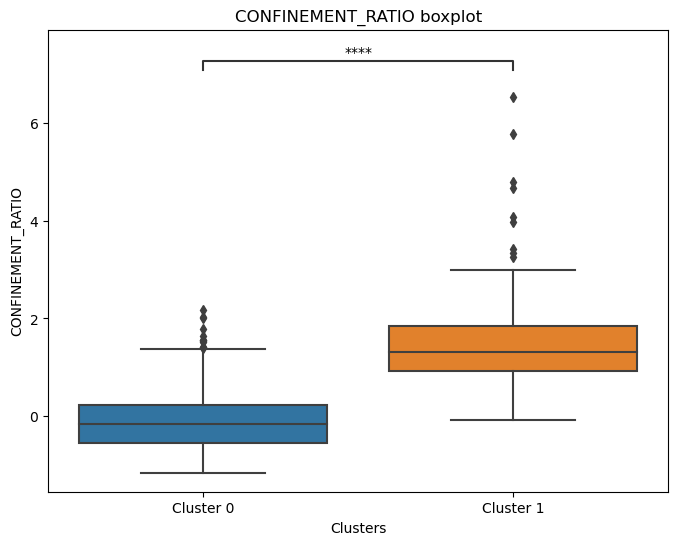

In [8]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(cr_df_merged, 
                              'Clusters', ['CONFINEMENT_RATIO'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.707e-58 U_stat=2.610e+03


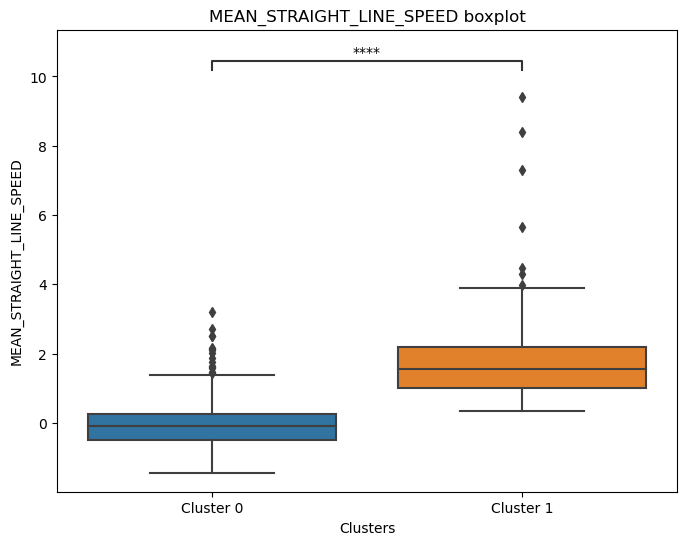

In [9]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(msls_df_merged, 
                              'Clusters', ['MEAN_STRAIGHT_LINE_SPEED'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.757e-15 U_stat=5.658e+04


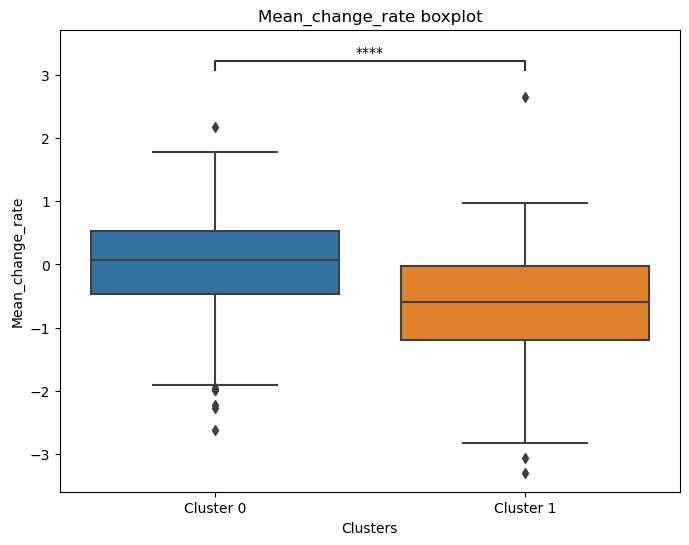

In [10]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(change_rate_df_merged, 
                              'Clusters', ['Mean_change_rate'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.037e-03 U_stat=4.518e+04


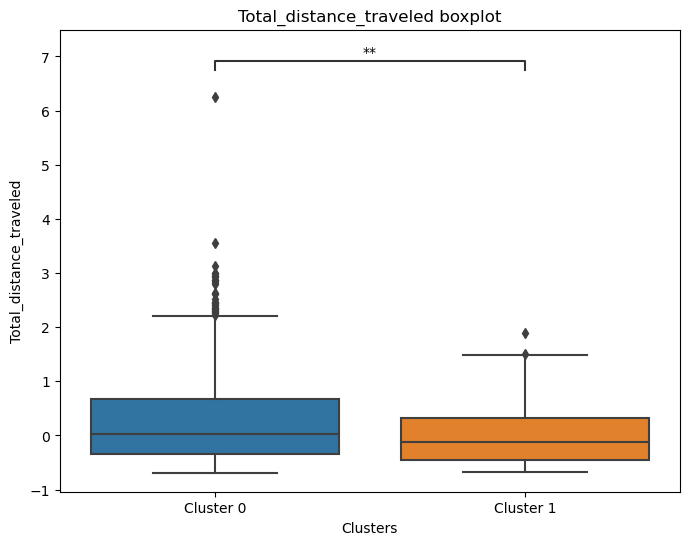

In [11]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(total_distance_df_merged, 
                              'Clusters', ['Total_distance_traveled'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.178e-01 U_stat=3.985e+04


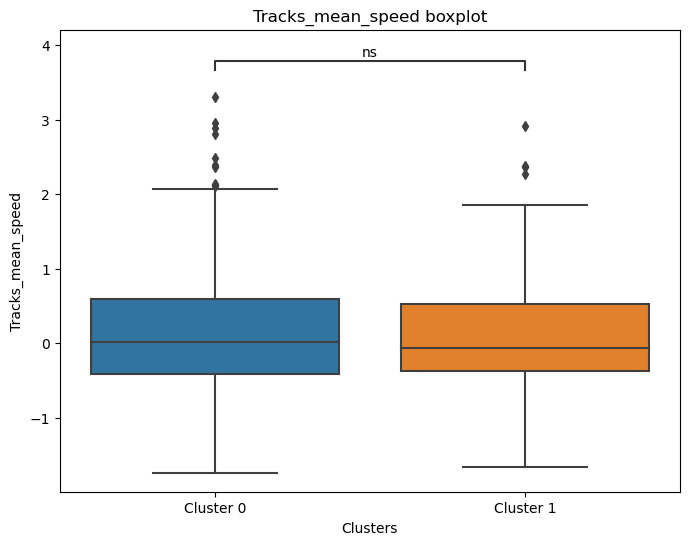

In [12]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(track_mean_speed_df_merged, 
                              'Clusters', ['Tracks_mean_speed'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:8.155e-01 U_stat=3.925e+04


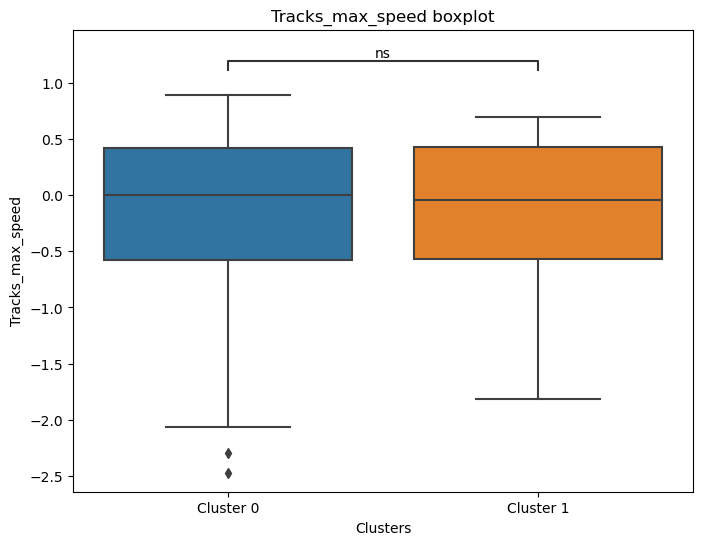

In [13]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(track_max_speed_df_merged, 
                              'Clusters', ['Tracks_max_speed'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.508e-01 U_stat=4.195e+04


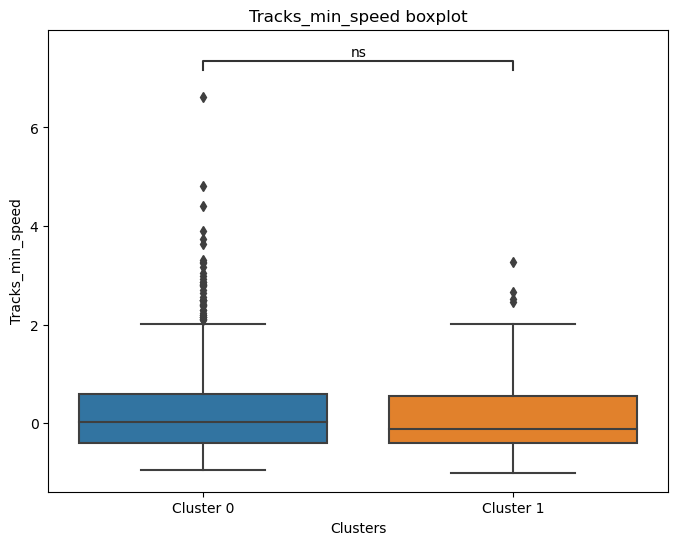

In [14]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(track_min_speed_df_merged, 
                              'Clusters', ['Tracks_min_speed'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.427e-01 U_stat=3.799e+04


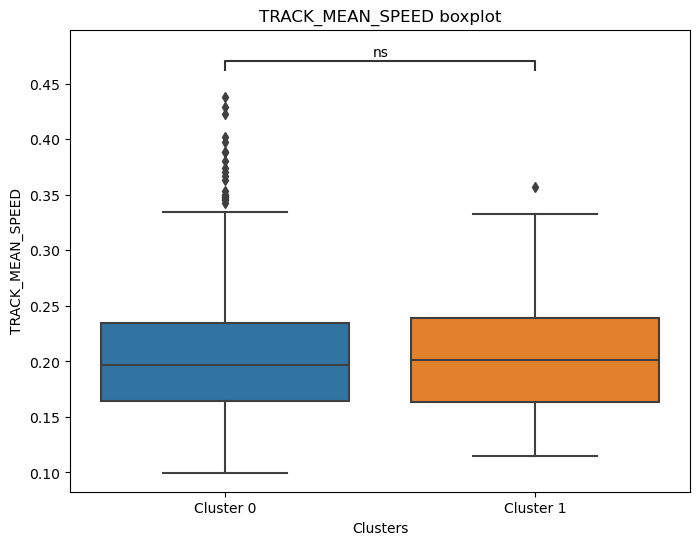

In [15]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(mean_speed_calc_df_merged, 
                              'Clusters', ['TRACK_MEAN_SPEED'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:8.882e-01 U_stat=3.841e+04


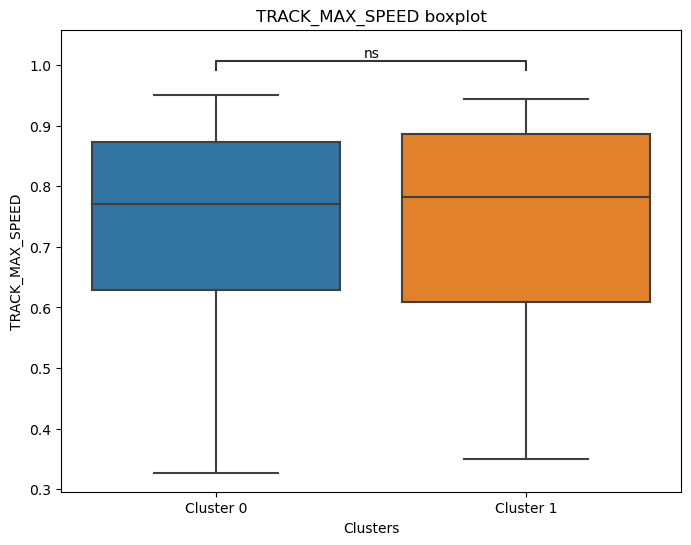

In [16]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(max_speed_calc_df_merged, 
                              'Clusters', ['TRACK_MAX_SPEED'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.595e-01 U_stat=3.941e+04


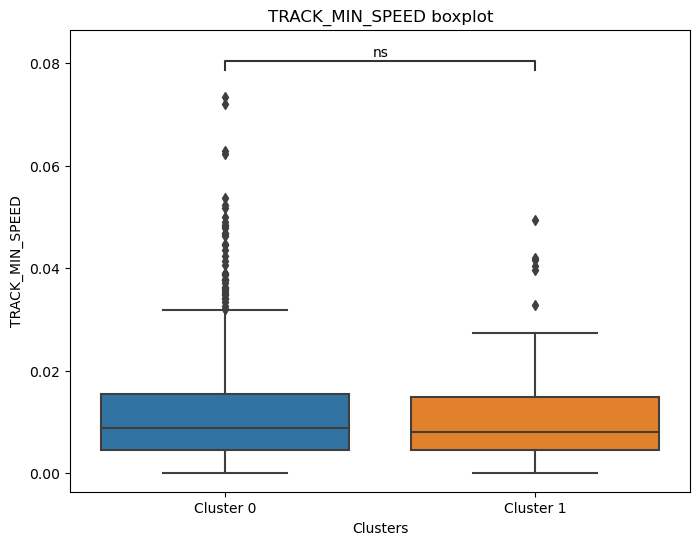

In [17]:
# calling of the function to perform test and add anottations to the plot
plot_boxplot_with_annotations(min_speed_calc_df_merged, 
                              'Clusters', ['TRACK_MIN_SPEED'])

### Clustering on merged set

In [22]:
# Function to merge data frames and create a mapping dictionary
def merge_and_map(dataframes_dict):
    data_frames = []
    name_to_index_map = {}
    current_index = 0

    for df_name, df in dataframes_dict.items():
        df['source'] = df_name
        data_frames.append(df)

        name_to_index_map[df_name] = {name: i for i, name in enumerate(df['Label'])}
    
    merged_df = pd.concat(data_frames, ignore_index=True, sort=False)
    
    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df, name_to_index_map

# Function to perform k-means clustering
def perform_k_means_clustering(df):
    # Performing kmeans for provided dataframe:
    # kmeans_fp - means fixed parameters
    kmeans_fp = KMeans(n_clusters=2, init='k-means++', n_init=50,
                      max_iter=10000, random_state=1)
    labels = kmeans_fp.fit_predict(df[['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED']])
    centroids = kmeans_fp.cluster_centers_
    
    return labels, centroids

# Read specific columns from CSV files
columns_to_read = ['Label', 'CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED']  # Specify the column names to read

df1 = pd.read_csv('tracks_df_scaled_1.csv', usecols=columns_to_read)
df2 = pd.read_csv('tracks_df_scaled_2.csv', usecols=columns_to_read)
df3 = pd.read_csv('tracks_df_scaled_3.csv', usecols=columns_to_read)
df4 = pd.read_csv('tracks_df_scaled_4.csv', usecols=columns_to_read)
df5 = pd.read_csv('tracks_df_scaled_5.csv', usecols=columns_to_read)

# Dictionary of data frames
dataframes_dict = {'df1': df1, 'df2': df2, 'df3': df3, 'df4': df4,'df5': df5}

# Call the function to merge data frames and create the mapping dictionary
merged_df, name_to_index_map = merge_and_map(dataframes_dict)

# Perform k-means clustering on the merged data frame and obtain labels and centroids
cluster_labels, cluster_centroids = perform_k_means_clustering(merged_df)

# Add cluster labels to the merged data frame
merged_df['Cluster_Labels'] = cluster_labels

# Map cluster labels to original data frames based on both 'name' and 'source'
for df_name, df in dataframes_dict.items():
    df['Cluster_Labels'] = df.apply(lambda row: merged_df[
        (merged_df['Label'] == row['Label']) & (merged_df['source'] == df_name)
    ]['Cluster_Labels'].values[0], axis=1)

# Show the updated original data frames with cluster labels
#for df_name, df in dataframes_dict.items():
#    print(f"Data Frame {df_name}:")
#    print(df)

# Show cluster centroids
#print("Cluster Centroids:")
#print(cluster_centroids)

# Saving merged_df
merged_df.to_csv('merged_df_all_5.csv', index = False)

# Save the updated data frames with '_w_cl' in their names
output_dir = 'output_data_frames'
os.makedirs(output_dir, exist_ok=True)

for df_name, df in dataframes_dict.items():
    output_file = os.path.join(output_dir, f"{df_name}_w_cl.csv")
    df.to_csv(output_file, index=False)

In [19]:
def plot_kmeans(labels, data, centroids):
    
    """
    Plots the data points and centroids for KMeans clustering.

    Args:
    labels (numpy.ndarray): The cluster labels for each data point.
    data (pandas.DataFrame): The input data used for clustering.
    centroids (numpy.ndarray): The centroids of each cluster.

    Returns:
    None
    """
    try:
        # Check that labels are a numpy aray:
        if not isinstance(labels, np.ndarray):
            raise TypeError('Labels must be a numpy array.')
        
        # Check that the data is a pandas Data frame:
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the centroids are a numpy array:
        if not isinstance(centroids, np.ndarray):
            raise TypeError('Centroids must be a numpay array')
            
        # Check that the data and the centroids have two columns:
        if data.shape[1] != 2 or centroids.shape[1] != 2:
            raise ValueError("Data and centroids must have two columns")
        
        # Creating the scatter plot od the data points:
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c = labels, cmap = 'viridis')

        # Ploting the centroids as black stars:
        plt.scatter(centroids[:, 0], centroids[:, 1], c ='black', marker = '*',
                   s = 150)

        list_of_features = list(data.columns)
        # Set the axis:
        plt.title(f"KMeans clustering\n({list_of_features[0]} vs. {list_of_features[1]})")
        plt.xlabel(list_of_features[0])
        plt.ylabel(list_of_features[1])
        
        # Saving the plot:
        plt.savefig(f'kmeans_{list_of_features[0]}_vs_{list_of_features[1]}.png')

        # Showing the plot:
        plt.show()
    
    except Exception as e:
        print(f"An error occured: {e}")
        traceback.print_exc()

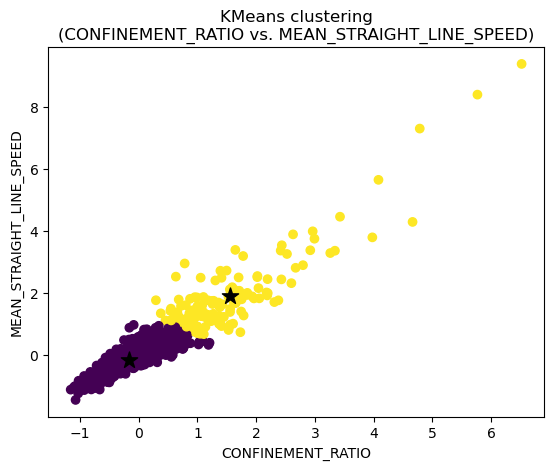

In [20]:
# Assuming we have cluster labels and centroids from k-means clustering
cluster_labels = merged_df['Cluster_Labels'].values
cluster_centroids = cluster_centroids  # Replace with your centroids data

# Call the plot_kmeans function
plot_kmeans(cluster_labels, merged_df[['CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED']], cluster_centroids)

### Calculating velocity across clusters

In [33]:
def calculate_mean_velocity_clusters(merged_df, dataframes_dict, num_points=500):
    try:
        dict_mean_velocity_clusters = {}

        # Iterate over unique cluster labels
        for cluster_id in merged_df['Cluster_Labels'].unique():
            cluster_df = merged_df[merged_df['Cluster_Labels'] == cluster_id]

            # Initialize an empty list to store velocities for all tracks in the cluster
            velocities_per_cluster = []

            # Iterate over rows in the cluster_df
            for index, row in cluster_df.iterrows():
                # Extract information for the current track
                label = row['Label']
                source = row['source']

                # Get the corresponding data frame based on the source
                df = dataframes_dict.get(source)

                if df is not None:
                    # Check if the label exists as a column name in the data frame
                    if label in df.columns:
                        # Extract velocities for the track from the column with the same name as the track
                        velocities = df[label].tolist()
                        
                        # Add the velocities to the list
                        velocities_per_cluster.append(velocities)
                    else:
                        print(f"Track '{label}' not found in data frame '{source}'")
                else:
                    print(f"Data frame '{source}' not found in dataframes_dict")

            # Calculate the mean velocity at each measurement point for the cluster
            mean_velocity_cluster = np.mean(velocities_per_cluster, axis=0)
            dict_mean_velocity_clusters[cluster_id] = mean_velocity_cluster.tolist()

        return dict_mean_velocity_clusters

    except Exception as e:
        print(f'An error occurs: {e}')
        traceback.print_exc()

In [34]:
#Reading the merged_df
merged_df_from_file = pd.read_csv('merged_df_all_5.csv')

# Read the df with the calculated velocities:
df_1_speed = pd.read_csv('df_track_speed_calculated_1.csv')
df_2_speed = pd.read_csv('df_track_speed_calculated_2.csv')
df_3_speed = pd.read_csv('df_track_speed_calculated_3.csv')
df_4_speed = pd.read_csv('df_track_speed_calculated_4.csv')
df_5_speed = pd.read_csv('df_track_speed_calculated_5.csv')


# Creating dataframes_dict:
dataframes_dict = {
    'df1': df_1_speed,
    'df2': df_2_speed,
    'df3': df_3_speed,
    'df4': df_4_speed,
    'df5': df_5_speed
}

In [35]:
consensus_velocity_of_clusters_dict = calculate_mean_velocity_clusters(merged_df_from_file, dataframes_dict)

In [38]:
def plot_mean_velocity_clusters(dict_mean_velocity_clusters):
    """
    Plot the mean velocity at each measurement point for each cluster.

    Args:
    - dict_mean_velocity_clusters: a dictionary of mean velocities at each measurement point for each cluster
    """
    try:
        for cluster_id, velocities in dict_mean_velocity_clusters.items():
            # Create plot for each cluster
            fig, ax = plt.subplots()
            ax.plot(velocities)
            ax.set_xlabel('Measurement Point')
            ax.set_ylabel('Mean speed')
            ax.set_title(f'Cluster {cluster_id}')
            plt.savefig(f'speed_vs_time_cluster_{cluster_id}.png')
            plt.show()

    except Exception as e:
        print(f'An error occurs: {e}')
        traceback.print_exc()

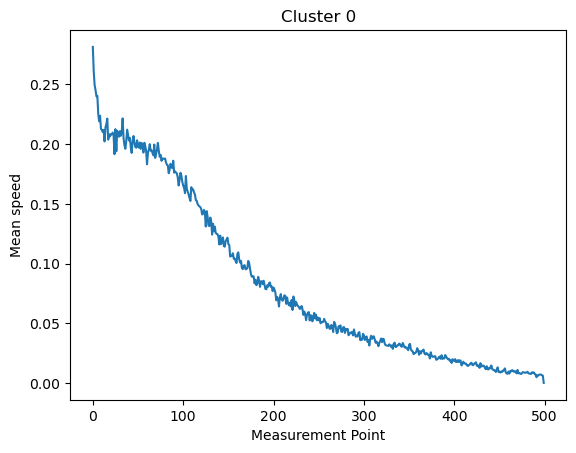

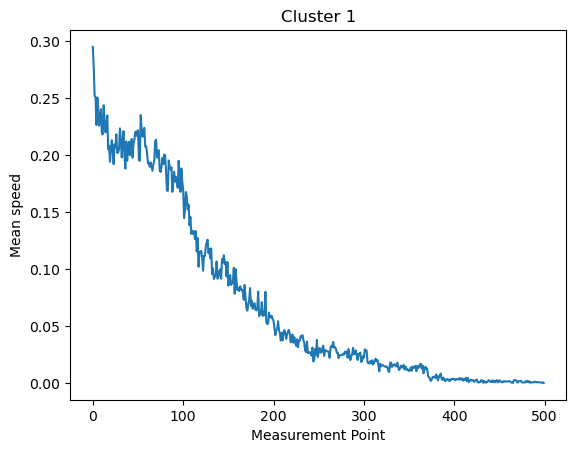

In [39]:
plot_mean_velocity_clusters(consensus_velocity_of_clusters_dict)